## Установка и импорт библиотек

In [1]:
! pip install -q transformers datasets evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.3 MB/s eta 0:00:00


In [2]:
import random
import gc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import StratifiedShuffleSplit

import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Subset
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils

from transformers import (
    AutoImageProcessor,
    AutoModelForImageClassification,
    DefaultDataCollator,
    TrainingArguments,
    Trainer,
)

import evaluate
from IPython.display import HTML
from tqdm.notebook import tqdm


random.seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## GAN

#### Установим параметры для сеток

In [3]:
IMAGE_SIZE = 64
NUM_CHANNELS = 1
LATENT_DIM = 100
GEN_FEATURE_MAPS = 64
DISC_FEATURE_MAPS = 64

#### Препроцессинг изображений

In [4]:
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

#### Загрузка данных

In [5]:
train_dataset = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform,
)

BATCH_SIZE = 256
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)


100%|██████████| 9.91M/9.91M [00:02<00:00, 4.63MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 135kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.09MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.56MB/s]


#### Определение архитектуры генератора, дискриминатора и инициализация весов

In [6]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [7]:
class Generator(nn.Module):
    def __init__(self, latent_vector_size, generator_feature_maps, num_channels):
        super(Generator, self).__init__()
        self.layers = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(latent_vector_size, generator_feature_maps * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(generator_feature_maps * 8),
            nn.ReLU(True),

            # state size: (generator_feature_maps*8) x 4 x 4
            nn.ConvTranspose2d(generator_feature_maps * 8, generator_feature_maps * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(generator_feature_maps * 4),
            nn.ReLU(True),

            # state size: (generator_feature_maps*4) x 8 x 8
            nn.ConvTranspose2d(generator_feature_maps * 4, generator_feature_maps * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(generator_feature_maps * 2),
            nn.ReLU(True),

            # state size: (generator_feature_maps*2) x 16 x 16
            nn.ConvTranspose2d(generator_feature_maps * 2, generator_feature_maps, 4, 2, 1, bias=False),
            nn.BatchNorm2d(generator_feature_maps),
            nn.ReLU(True),

            # state size: (generator_feature_maps) x 32 x 32
            nn.ConvTranspose2d(generator_feature_maps, num_channels, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size: (num_channels) x 64 x 64
        )

    def forward(self, input):
        return self.layers(input)


In [8]:
class Discriminator(nn.Module):
    def __init__(self, discriminator_feature_maps, num_channels):
        super(Discriminator, self).__init__()
        self.layers = nn.Sequential(
            # input is (num_channels) x 64 x 64
            nn.Conv2d(num_channels, discriminator_feature_maps, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            # state size: (discriminator_feature_maps) x 32 x 32
            nn.Conv2d(discriminator_feature_maps, discriminator_feature_maps * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(discriminator_feature_maps * 2),
            nn.LeakyReLU(0.2, inplace=True),

            # state size: (discriminator_feature_maps*2) x 16 x 16
            nn.Conv2d(discriminator_feature_maps * 2, discriminator_feature_maps * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(discriminator_feature_maps * 4),
            nn.LeakyReLU(0.2, inplace=True),

            # state size: (discriminator_feature_maps*4) x 8 x 8
            nn.Conv2d(discriminator_feature_maps * 4, discriminator_feature_maps * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(discriminator_feature_maps * 8),
            nn.LeakyReLU(0.2, inplace=True),

            # state size: (discriminator_feature_maps*8) x 4 x 4
            nn.Conv2d(discriminator_feature_maps * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.layers(input)

In [9]:
generator = Generator(
    latent_vector_size=LATENT_DIM,
    generator_feature_maps=GEN_FEATURE_MAPS,
    num_channels=NUM_CHANNELS
).to(device)
generator.apply(weights_init)

Generator(
  (layers): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )


In [10]:
discriminator = Discriminator(
    discriminator_feature_maps=DISC_FEATURE_MAPS,
    num_channels=NUM_CHANNELS
).to(device)
discriminator.apply(weights_init)

Discriminator(
  (layers): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

#### Определяем параметры обучения GAN

In [11]:
loss_fn = nn.BCELoss()

fixed_noise = torch.randn(64, LATENT_DIM, 1, 1, device=device)

REAL_LABEL = 1.
FAKE_LABEL = 0.

LEARNING_RATE = 3e-4

optimizer_disc = optim.Adam(discriminator.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
optimizer_gen = optim.Adam(generator.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))

#### Обучаем наш GAN

In [12]:
NUM_EPOCHS = 10

generated_images = []
gen_losses = []
disc_losses = []
iteration = 0

for epoch in range(1, NUM_EPOCHS + 1):
    total_gen_loss = 0.0
    total_disc_loss = 0.0
    batch_count = 0

    progress = tqdm(train_loader, desc=f"Epoch {epoch}/{NUM_EPOCHS}")
    for real_batch in progress:
        real_imgs = real_batch[0].to(device)
        batch_size = real_imgs.size(0)

        # Train Discriminator
        discriminator.zero_grad()

        labels_real = torch.full((batch_size,), REAL_LABEL, device=device)
        output_real = discriminator(real_imgs).view(-1)
        loss_real = loss_fn(output_real, labels_real)

        noise = torch.randn(batch_size, LATENT_DIM, 1, 1, device=device)
        fake_imgs = generator(noise)
        labels_fake = torch.full((batch_size,), FAKE_LABEL, device=device)
        output_fake = discriminator(fake_imgs.detach()).view(-1)
        loss_fake = loss_fn(output_fake, labels_fake)

        disc_loss = loss_real + loss_fake
        disc_loss.backward()
        optimizer_disc.step()

        # Train Generator
        generator.zero_grad()

        labels_gen = torch.full((batch_size,), REAL_LABEL, device=device)
        output_for_gen = discriminator(fake_imgs).view(-1)
        gen_loss = loss_fn(output_for_gen, labels_gen)
        gen_loss.backward()
        optimizer_gen.step()

        # Record losses
        gen_losses.append(gen_loss.item())
        disc_losses.append(disc_loss.item())
        total_gen_loss += gen_loss.item()
        total_disc_loss += disc_loss.item()
        batch_count += 1

        progress.set_postfix({
            "Gen Loss": f"{gen_loss.item():.4f}",
            "Disc Loss": f"{disc_loss.item():.4f}",
        })

        # Save generated images at intervals
        if iteration % 500 == 0 or (epoch == NUM_EPOCHS and batch_count == len(train_loader)):
            with torch.no_grad():
                sample = generator(fixed_noise).detach().cpu()
            generated_images.append(vutils.make_grid(sample, padding=2, normalize=True))

        iteration += 1

    avg_gen_loss = total_gen_loss / batch_count
    avg_disc_loss = total_disc_loss / batch_count
    print(
        f"Epoch {epoch} complete | Avg Gen Loss: {avg_gen_loss:.4f} | Avg Disc Loss: {avg_disc_loss:.4f}"
    )


Epoch 1/10:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 1 complete | Avg Gen Loss: 7.3103 | Avg Disc Loss: 0.7898


Epoch 2/10:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 2 complete | Avg Gen Loss: 2.6720 | Avg Disc Loss: 0.7236


Epoch 3/10:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 3 complete | Avg Gen Loss: 2.0525 | Avg Disc Loss: 0.8327


Epoch 4/10:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 4 complete | Avg Gen Loss: 2.3757 | Avg Disc Loss: 0.7541


Epoch 5/10:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 5 complete | Avg Gen Loss: 2.9388 | Avg Disc Loss: 0.7204


Epoch 6/10:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 6 complete | Avg Gen Loss: 3.1082 | Avg Disc Loss: 0.6950


Epoch 7/10:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 7 complete | Avg Gen Loss: 3.0496 | Avg Disc Loss: 0.6693


Epoch 8/10:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 8 complete | Avg Gen Loss: 3.0216 | Avg Disc Loss: 0.6821


Epoch 9/10:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 9 complete | Avg Gen Loss: 2.8876 | Avg Disc Loss: 0.6729


Epoch 10/10:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 10 complete | Avg Gen Loss: 2.9472 | Avg Disc Loss: 0.6763


#### Посмотрим на обучающие лоссы генератора и дискриминатора

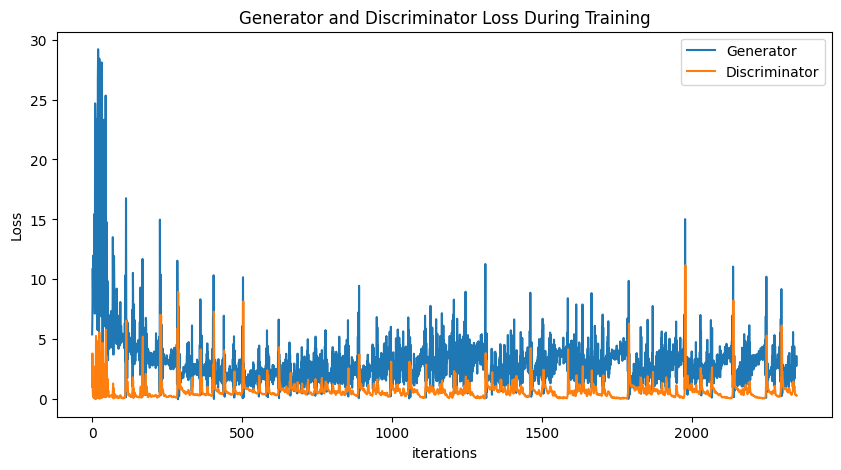

In [13]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(gen_losses,label="Generator")
plt.plot(disc_losses,label="Discriminator")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

#### Поглядим, чему научился наш генератор

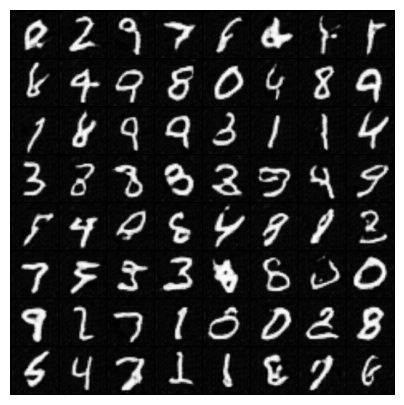

In [14]:
fig = plt.figure(figsize=(5,5))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in generated_images]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

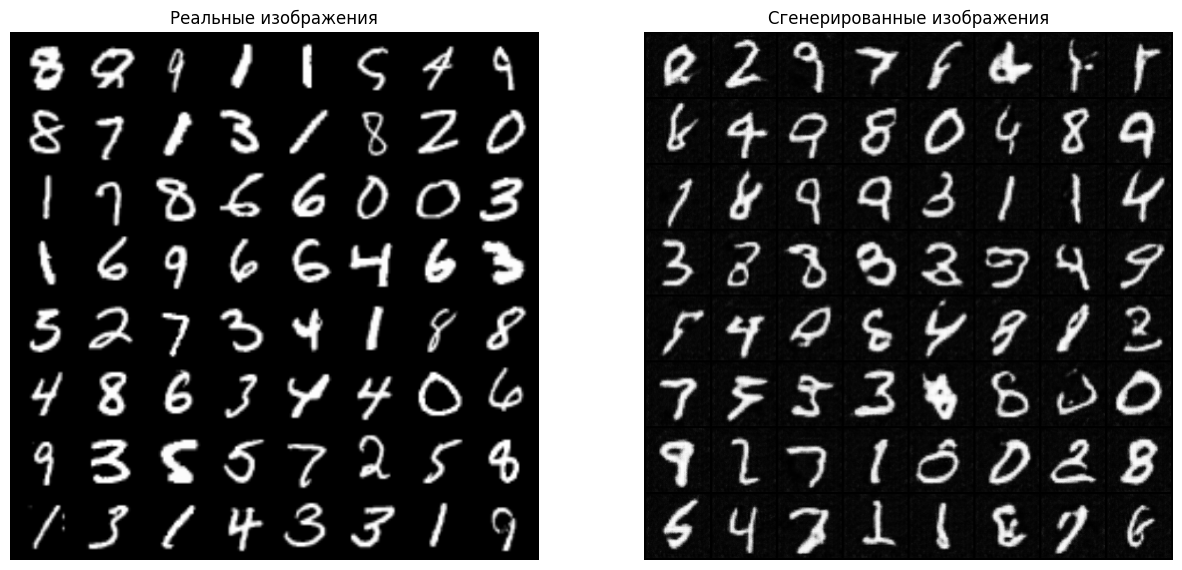

In [15]:
# Получаем батч реальных изображений из загрузчика данных
real_batch = next(iter(train_loader))

# Отображаем реальные изображения
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Реальные изображения")
plt.imshow(
    np.transpose(
        vutils.make_grid(
            real_batch[0].to(device)[:64],
            padding=5,
            normalize=True
        ).cpu(),
        (1,2,0)
    )
)

# Отображаем Сгенерированные изображения из последней эпохи
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Сгенерированные изображения")
plt.imshow(np.transpose(generated_images[-1], (1,2,0)))
plt.show()


#### Выводы

Самый главный вывод заключается в том, что GAN очень сложно нормально обучить. Несколько раз в процессе экспериментов обучение разваливалось: лосс дискриминатора улетал в космос, а у генератора в 0. Пришлось колдовать с параметрами обучения и инициализацией весов

#### Reference
Использовал pytorch-tutorial для обучения сверточного GAN:  
https://docs.pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

## Vision Transformer

#### Загрузка данных

In [16]:
def stratified_sample(dataset, sample_size, random_state=42):
    targets = np.array(dataset.targets)
    splitter = StratifiedShuffleSplit(n_splits=1, train_size=sample_size, random_state=random_state)
    indices, _ = next(splitter.split(np.zeros(len(targets)), targets))

    return Subset(dataset, indices)

In [17]:
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True)
eval_dataset  = datasets.FashionMNIST(root='./data', train=False, download=True)

# сэмплируем для train датасета 5к примеров из исходных данных, для теста - 1к
train_dataset = stratified_sample(train_dataset, 5000)
eval_dataset = stratified_sample(eval_dataset, 1000)

100%|██████████| 26.4M/26.4M [00:02<00:00, 10.5MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 175kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.31MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 14.6MB/s]


#### Загрузка модели с hf

In [18]:
model_name = "google/vit-base-patch16-224"
model = AutoModelForImageClassification.from_pretrained(model_name, num_labels=10, ignore_mismatched_sizes=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### Заморозка модели (оставляем только классификационную голову)

In [19]:
for name, param in model.named_parameters():
    if not name.startswith("classifier"):
        param.requires_grad = False

#### Препроцессинг данных

In [20]:
processor = AutoImageProcessor.from_pretrained(model_name)

def data_collator(batch, processor=processor):
  images, labels = zip(*batch)
  images = [img.convert('RGB') for img in images]
  inputs = processor(images=images, return_tensors='pt')
  inputs['labels'] = torch.tensor(labels, dtype=torch.long)
  return inputs

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


#### Подсчет метрик

In [21]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    acc = (preds == labels).mean()

    precision_micro = precision_score(labels, preds, average='micro')
    precision_macro = precision_score(labels, preds, average='macro')
    recall_micro = recall_score(labels, preds, average='micro')
    recall_macro = recall_score(labels, preds, average='macro')
    f1_micro = f1_score(labels, preds, average='micro')
    f1_macro = f1_score(labels, preds, average='macro')

    return {
        'accuracy': acc,
        'precision_micro': precision_micro,
        'precision_macro': precision_macro,
        'recall_micro': recall_micro,
        'recall_macro': recall_macro,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro
    }

#### Обучаем модель

In [22]:
training_args = TrainingArguments(
    per_device_train_batch_size=256,
    per_device_eval_batch_size=256,
    logging_strategy='epoch',
    eval_strategy='epoch',
    save_strategy='epoch',
    learning_rate=2e-5,
    num_train_epochs=10,
    load_best_model_at_end=True,
    metric_for_best_model='precision_macro',
    report_to='none'
)

In [23]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [24]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision Micro,Precision Macro,Recall Micro,Recall Macro,F1 Micro,F1 Macro
1,2.329600,2.289242,0.128000,0.128000,0.142329,0.128000,0.128000,0.128000,0.094144
2,2.247200,2.213520,0.172000,0.172000,0.167182,0.172000,0.172000,0.172000,0.136278
3,2.177300,2.149285,0.216000,0.216000,0.194176,0.216000,0.216000,0.216000,0.182915
4,2.118600,2.095999,0.261000,0.261000,0.241242,0.261000,0.261000,0.261000,0.225851
5,2.070700,2.052240,0.296000,0.296000,0.271517,0.296000,0.296000,0.296000,0.260558
6,2.032500,2.017096,0.331000,0.331000,0.309229,0.331000,0.331000,0.331000,0.298072
7,1.999500,1.990315,0.349000,0.349000,0.322181,0.349000,0.349000,0.349000,0.316150
8,1.976400,1.971524,0.363000,0.363000,0.334886,0.363000,0.363000,0.363000,0.331957
9,1.962900,1.960288,0.370000,0.370000,0.342101,0.370000,0.370000,0.370000,0.339087
10,1.954400,1.956463,0.374000,0.374000,0.346433,0.374000,0.374000,0.374000,0.343394


TrainOutput(global_step=200, training_loss=2.0869155883789063, metrics={'train_runtime': 982.6673, 'train_samples_per_second': 50.882, 'train_steps_per_second': 0.204, 'total_flos': 3.8748772952064e+18, 'train_loss': 2.0869155883789063, 'epoch': 10.0})

#### Оценка модели

In [25]:
predictions = trainer.predict(eval_dataset)

In [26]:
predictions = trainer.predict(eval_dataset)
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)

report = classification_report(y_true, y_pred, digits=4)
print(report)

              precision    recall  f1-score   support

           0     0.3103    0.1800    0.2278       100
           1     0.4645    0.8500    0.6007       100
           2     0.4071    0.4600    0.4319       100
           3     0.4615    0.2400    0.3158       100
           4     0.1190    0.0500    0.0704       100
           5     0.4634    0.5700    0.5112       100
           6     0.1743    0.1900    0.1818       100
           7     0.3758    0.6200    0.4679       100
           8     0.1719    0.1100    0.1341       100
           9     0.5165    0.4700    0.4921       100

    accuracy                         0.3740      1000
   macro avg     0.3464    0.3740    0.3434      1000
weighted avg     0.3464    0.3740    0.3434      1000



#### Выводы
1. ViT учится сильно дольше сверточных сеток
2. В моем случае качество на задаче классификации получилось хуже, чем с resnet. Думаю, что это связано с тем, что я обучал его очень мало и на маленьком сэмпле данных

P.S. на этом же датасете обучал resnet в предыдущей домашке, поэтому в этой заново делать это не стал, просто сравнил результаты там и тут

#### Reference  
Использовал гайд от huggingface для обучения ViT для классификации изображений:  
https://huggingface.co/docs/transformers/en/tasks/image_classification